# Normalization Notebook
In this notebook I normalize the whole dataset so that we do not need to do it on the fly when training the model
Below I also test some of the transforms that were generated

In [1]:
from embed_time.transforms import complex_normalisation
import os
import skimage.io as io

data_location = "/mnt/efs/dlmbl/G-et/data/live-TLS"

folder_imgs = data_location +"/"+'Control_Dataset_4TP'
metadata = data_location + "/" +'Control_Dataset_4TP_Ground_Truth'
out_normalised = data_location + "/" +'Control_Dataset_4TP_Normalized'
if not os.path.isdir(out_normalised):
    os.mkdir(out_normalised)

img_list = [path for path in os.listdir(folder_imgs) if path.endswith(".tif")]
img_list


['CTRLD_TR_PLATE_2_ID_G9.tif',
 'CTRLD_RR_PLATE_6_ID_E9.tif',
 'CTRLD_RR_PLATE_1_ID_B10.tif',
 'CTRLD_RR_PLATE_4_ID_G9.tif',
 'CTRLD_RR_PLATE_1_ID_B1.tif',
 'CTRLD_RR_PLATE_1_ID_A2.tif',
 'CTRLD_RR_PLATE_4_ID_H8.tif',
 'CTRLD_RR_PLATE_6_ID_H6.tif',
 'CTRLD_TR_PLATE_1_ID_H9.tif',
 'CTRLD_RR_PLATE_1_ID_H3.tif',
 'CTRLD_RR_PLATE_4_ID_F2.tif',
 'CTRLD_TR_PLATE_2_ID_D4.tif',
 'CTRLD_TR_PLATE_1_ID_H10.tif',
 'CTRLD_TR_PLATE_1_ID_B7.tif',
 'CTRLD_TR_PLATE_1_ID_F12.tif',
 'CTRLD_RR_PLATE_4_ID_B6.tif',
 'CTRLD_RR_PLATE_1_ID_D7.tif',
 'CTRLD_TR_PLATE_1_ID_F3.tif',
 'CTRLD_RR_PLATE_1_ID_B9.tif',
 'CTRLD_TR_PLATE_1_ID_D5.tif',
 'CTRLD_TR_PLATE_1_ID_G11.tif',
 'CTRLD_TR_PLATE_2_ID_B6.tif',
 'CTRLD_RR_PLATE_1_ID_F5.tif',
 'CTRLD_RR_PLATE_6_ID_C12.tif',
 'CTRLD_RR_PLATE_4_ID_G1.tif',
 'CTRLD_TR_PLATE_2_ID_E3.tif',
 'CTRLD_RR_PLATE_6_ID_C3.tif',
 'CTRLD_TR_PLATE_2_ID_E12.tif',
 'CTRLD_TR_PLATE_1_ID_C6.tif',
 'CTRLD_RR_PLATE_6_ID_E10.tif',
 'CTRLD_RR_PLATE_4_ID_C5.tif',
 'CTRLD_RR_PLATE_1_ID_E6.tif',
 

In [4]:
import numpy as np
img = io.imread(folder_imgs+"/"+img_list[0])
img[0][0]

array([[177.58008, 176.13235, 176.82385, ..., 179.91472, 181.3131 ,
        184.23067],
       [176.80244, 176.21324, 175.5107 , ..., 180.11528, 179.73907,
        181.74521],
       [177.29095, 177.8136 , 177.93512, ..., 181.41336, 180.40445,
        181.68164],
       ...,
       [172.38713, 173.02652, 176.30809, ..., 176.55867, 176.17668,
        177.1237 ],
       [175.85606, 174.04015, 174.0906 , ..., 176.68631, 174.81784,
        176.36981],
       [171.52225, 171.794  , 174.14056, ..., 177.49547, 175.22604,
        177.27545]], dtype=float32)

In [21]:
len(np.histogram(img[2][0], bins=range(1,256))[1])



255

/home/S-rs/miniforge3/envs/embed_time/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


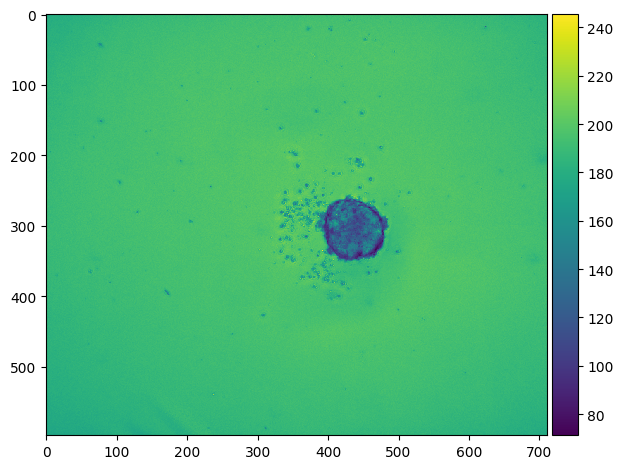

In [28]:
names =[]
BF = []
BF_imgs = []
BRA_imgs = []
BRA = []
for pth in img_list:
    img = io.imread(folder_imgs+"/"+pth)
    names.append(pth)
    BF.append([np.histogram(img[i][0], bins=range(1,256))[0] for i in range(4)])
    BF_imgs.append(img[:,0])
    BRA.append([np.histogram(img[i][1], bins=range(1,256))[0] for i in range(4)])
    BRA_imgs.append(img[:,1])

io.imshow(BF_imgs[0][0])

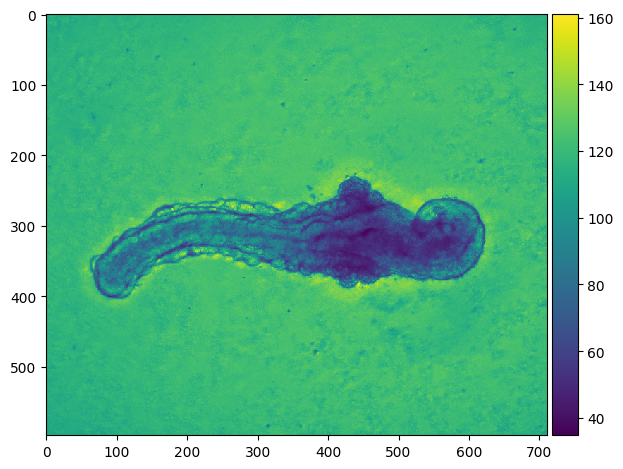

In [29]:
io.imshow(BF_imgs[0][3])

In [30]:
BF = np.array(BF)
BF.shape

(312, 4, 254)

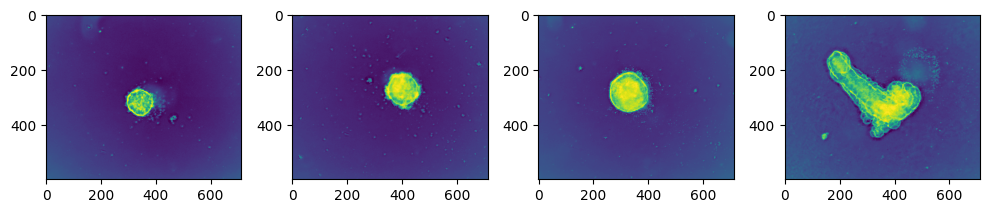

In [16]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,4,figsize=(10,5))
for i,ax in enumerate(axs):
    ax.imshow(img[i][0])
plt.tight_layout()

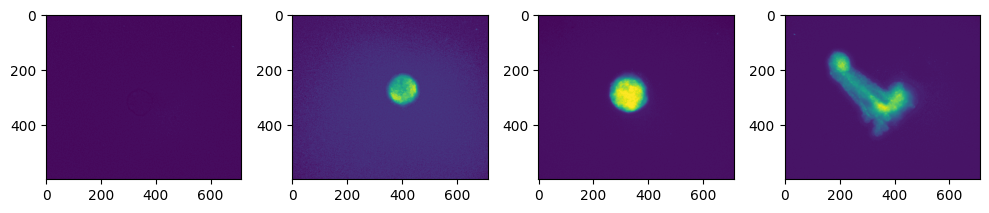

In [17]:
fig,axs = plt.subplots(1,4,figsize=(10,5))
for i,ax in enumerate(axs):
    ax.imshow(img[i][1])
plt.tight_layout()

In [18]:
import torchvision.transforms as trans
from torchvision.transforms import v2
from embed_time.transforms import CustomToTensor


loading_transforms = trans.Compose([
    CustomToTensor()
])

dataset_w_t = LiveTLSDataset(
    metadata,
    out_normalised,
    metadata_columns=["Run","Plate","ID"],
    return_metadata=True,
    transform = loading_transforms,
)

tensor, l, m = dataset_w_t[0]
tensor.shape

# Doesn't work need to make our own to tensor

torch.Size([4, 2, 598, 712])

In [19]:
from embed_time.transforms import SelectRandomTimepoint

sel_tp = SelectRandomTimepoint(time_dimension=0)

sel_tp(tensor).shape

torch.Size([2, 598, 712])